In [1]:
import skyproj 
import healpy as hp
import numpy as np
from astropy.coordinates import SkyCoord

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.colors import ListedColormap
import astropy.units as u

# Load Footprints

Load in the footprints for 
- HLWAS Medium
- HLWAS Wide
- GPS
- LSST WFD Baseline 4.0

Create footprint for 
- DESI 2 high z

This has functions to get footprint maps nside=256 and then return them in a dict that can be used for plotting


In [2]:


def make_desi_healpix_mask(nside=512, return_boolean=False):
    """
    Create a DESI-style HEALPix mask with two new piecewise RA/Dec/b regions.

    Regions included:

    Region 1:
      -18 < DEC < +3
      b < -27 for RA > 270
      b < -47 for RA < 90

    Region 2:
      -7 < DEC < +15
      b > 22 for RA < 180
      b > 30 for RA > 180, DEC > 1
      b > 46 for RA > 180, DEC > -10

    Parameters
    ----------
    nside : int
        HEALPix NSIDE
    return_boolean : bool
        If True, return boolean array of shape (npix,)
        If False, return float HEALPix map with 1.0 and hp.UNSEEN

    Returns
    -------
    mask : ndarray
        Boolean mask or HEALPix map suitable for plotting
    """
    npix = hp.nside2npix(nside)

    # HEALPix pixel centers → RA/Dec
    theta, phi = hp.pix2ang(nside, np.arange(npix))
    ra  = np.degrees(phi)
    dec = 90.0 - np.degrees(theta)

    # Convert to Galactic coordinates
    coords = SkyCoord(ra=ra * u.deg, dec=dec * u.deg, frame="icrs")
    b = coords.galactic.b.deg

    # --- Region 1 ---
    mask1 = np.zeros(npix, dtype=bool)
    dec_r1 = (dec > -18) & (dec < 3)
    ra_gt_270 = ra > 270
    ra_lt_90  = ra < 90
    mask1[dec_r1 & ra_gt_270 & (b < -27)] = True
    mask1[dec_r1 & ra_lt_90  & (b < -47)] = True

    # --- Region 2 ---
    mask2 = np.zeros(npix, dtype=bool)
    dec_r2 = (dec > -7) & (dec < 15)
    ra_lt_180 = ra < 180
    ra_gt_180 = ra > 180

    # b > 22 for RA < 180
    mask2[dec_r2 & ra_lt_180 & (b > 22)] = True
    # b > 30 for RA > 180 and DEC > 1
    mask2[dec_r2 & ra_gt_180 & (dec > 1) & (b > 30)] = True
    # b > 46 for RA > 180 and DEC > -10
    mask2[dec_r2 & ra_gt_180 & (dec > -10) & (b > 46)] = True

    # Combine the two regions
    mask_bool = mask1 | mask2

    if return_boolean:
        return mask_bool

    # HEALPix-style map
    mask_hpx = np.full(npix, hp.UNSEEN, dtype=float)
    mask_hpx[mask_bool] = 1.0

    return mask_hpx

def load_footprints_npz(npz_path):
    """
    Load a .npz created by `save_layers_npz` and return a layers dict.

    Returns a dict mapping layer name -> {'map': numpy_array}.
    """
    data = np.load(npz_path)
    layers = {}
    for name in data.files:
        m = data[name]
        m = np.asarray(m, dtype=float)
        layers[name] = {"map": m}
    return layers

def create_survey_footprints_dict(npz_path, color_map=None, zorder_map=None,
                       default_color="#888888", default_zorder=9):
    """
    Load maps from `npz_path` and return a `footprints` dict suitable for
    plotting. Each entry will be a dict with keys: 'map', 'color', 'zorder'.

    Parameters
    - npz_path: str
        Path to the .npz produced by `save_layers_npz`.
    - color_map: dict or None
        Optional mapping layer_name -> color string to override defaults.
    - zorder_map: dict or None
        Optional mapping layer_name -> zorder int to override defaults.
    - default_color: str
        Fallback color for unknown layers.
    - default_zorder: int
        Fallback zorder for unknown layers.

    Returns
    - footprints: dict
        Mapping layer name -> {'map': array, 'color': str, 'zorder': int}
    """
    layers = load_footprints_npz(npz_path)

    # sensible defaults for common names
    _color_defaults = {
        "HLWAS Wide": "#4C72B0",
        "HLWAS Medium": "#DD8452",
        "GPS": "#55A868",
        "LSST WFD": "#2CB1A1",
    }
    _zorder_defaults = {
        "HLWAS Wide": 9,
        "HLWAS Medium": 10,
        "GPS": 7,
        "LSST WFD": 7,
    }
    _alpha_defaults = {
        "HLWAS Wide": 0.5,
        "HLWAS Medium": 0.75,
        "GPS": 0.5,
        "LSST WFD": 0.5,
    }
    

    footprints = {}
    for name, entry in layers.items():
        cmap = None
        zord = None
        alpha = None
        if color_map and name in color_map:
            cmap = color_map[name]
        if zorder_map and name in zorder_map:
            zord = zorder_map[name]

        if cmap is None:
            cmap = _color_defaults.get(name, default_color)
        if zord is None:
            zord = _zorder_defaults.get(name, default_zorder)
        if alpha is None:
            alpha = _alpha_defaults.get(name, 1.0)

        footprints[name] = {"map": entry["map"], "color": cmap, "zorder": zord, "alpha": alpha}

    return footprints

In [59]:
ebv_path="../data/ebv_sfd98_lowres_nside_256_ring_equatorial.fits"
ebv_map = hp.read_map(ebv_path)
ebv_map = hp.ud_grade(
            ebv_map,
            nside_out=256,
            order_in="RING",
            order_out="RING"
        )

In [60]:
import numpy as np
import healpy as hp

import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy.coordinates import Galactic, BarycentricTrueEcliptic


def make_euclid_wide_healpix_mask(
    nside=256,
    ebv_max=0.09,
    ebv_path="../data/ebv_sfd98_lowres_nside_256_ring_equatorial.fits",
    return_boolean=False,
    remove_northern_island=True,
):
    """
    Euclid Wide Survey HEALPix footprint mask following RSD2023A RoI logic,
    using a precomputed equatorial HEALPix E(B-V) dust map.

    Assumptions
    -----------
    - E(B-V) map is:
        * HEALPix
        * NSIDE = 512
        * RING ordering
        * Equatorial (ICRS)
    """

    npix = hp.nside2npix(nside)

    # ------------------------------------------------------------
    # HEALPix pixel centers → ICRS
    # ------------------------------------------------------------
    theta, phi = hp.pix2ang(nside, np.arange(npix))
    ra  = np.degrees(phi)
    dec = 90.0 - np.degrees(theta)

    coords = SkyCoord(
        ra=ra * u.deg,
        dec=dec * u.deg,
        frame="icrs"
    )

    # ------------------------------------------------------------
    # Ecliptic latitude cut
    # ------------------------------------------------------------
    ecl = coords.transform_to(BarycentricTrueEcliptic())
    beta = ecl.lat.deg
    mask_ecl = np.abs(beta) > 10.0

    # ------------------------------------------------------------
    # Galactic latitude cut (GC vs anticenter)
    # ------------------------------------------------------------
    gal = coords.transform_to(Galactic())
    b = gal.b.deg
    l = gal.l.deg

    delta_l = np.abs((l - 180 + 180) % 360 - 180)
    is_anticenter = delta_l < 90.0
    is_center     = ~is_anticenter

    mask_gal = np.zeros(npix, dtype=bool)
    mask_gal[is_center     & (np.abs(b) > 23.0)] = True
    mask_gal[is_anticenter & (np.abs(b) > 20.0)] = True

    # ------------------------------------------------------------
    # Dust extinction cut (from HEALPix map)
    # ------------------------------------------------------------
    ebv_map = hp.read_map(ebv_path, verbose=False)

    ebv_nside = hp.get_nside(ebv_map)
    if ebv_nside != nside:
        ebv_map = hp.ud_grade(
            ebv_map,
            nside_out=nside,
            order_in="RING",
            order_out="RING"
        )

    mask_ebv = ebv_map <= ebv_max

    # ------------------------------------------------------------
    # Combine RoI cuts
    # ------------------------------------------------------------
    mask_bool = mask_ecl & mask_gal & mask_ebv

    # ------------------------------------------------------------
    # Remove northern island (optional)
    # ------------------------------------------------------------
    if remove_northern_island:
        mask_bool &= (((dec <= 3.0) & (b < 0)) | (b > 0))

    if return_boolean:
        return mask_bool

    # ------------------------------------------------------------
    # HEALPix-style map
    # ------------------------------------------------------------
    mask_hpx = np.full(npix, hp.UNSEEN, dtype=float)
    mask_hpx[mask_bool] = 1.0

    return mask_hpx


In [66]:
nside = 256
npix = hp.nside2npix(nside)

other_footprints_dict = create_survey_footprints_dict("../data/survey_footprints_nside256.npz")
other_footprints_dict['DESI-2 High z'] = {
    "map": make_desi_healpix_mask(nside=256),
    "color": "#937860",
    "zorder": 8,
    "alpha": 0.75,
}
other_footprints_dict['Euclid Wide'] = {
    "map": make_euclid_wide_healpix_mask(nside=256),
    "color": '#7A1E9D',
    "zorder": 8,
    "alpha": 0.75,
}

/tmp/ipykernel_73151/1021909249.py:69: HealpyDeprecationWarning: "verbose" was deprecated in version 1.15.0 and will be removed in a future version. 
  ebv_map = hp.read_map(ebv_path, verbose=False)


# 2 Create proposed footprints
Using the other footprints we want to select areas that overlap with LSST WFD and do not overlap with HLWAS medium/wide. 
The ra_min/max and dec_min/max can be changed

In [67]:
def create_southern_footprint(
        footprints, ra_min, ra_max, nside,
        dec_min=-65.0, dec_max=-30.0,
        hlwas_wide_names=None,
        hlwas_medium_names=None,
        exclude_mask=None
    ):
    """
    Build a southern footprint from a `footprints` dict (mapping names ->
    {'map': array, ...}). Uses the LSST map inside `footprints` as the base
    and then sets pixels to `hp.UNSEEN` where HLWAS wide/medium maps have
    coverage.

    Parameters
    - footprints: dict
        Mapping layer name -> dict containing at least the key 'map'.
    - ra_min, ra_max, nside, dec_min, dec_max: as in `create_southern_footprint`.
    - hlwas_wide_names, hlwas_medium_names: list or None
        Optional lists of candidate keys for HLWAS wide/medium in `footprints`.
        If None, sensible defaults will be used.
    - exclude_mask: optional mask applied after HLWAS masking.

    Returns
    - footprint map (numpy array) with values 1.0 or hp.UNSEEN.
    """
    # Minimal, clear version that assumes all maps already have `nside`.
    # It expects exact keys: 'LSST WFD', 'HLWAS Wide', 'HLWAS Medium'.
    lsst_map = footprints["LSST WFD"]["map"]
    hw = footprints["HLWAS Wide"]["map"]
    hm = footprints["HLWAS Medium"]["map"]

    # require matching nside
    for name, arr in ("LSST WFD", lsst_map), ("HLWAS Wide", hw), (
        "HLWAS Medium", hm
    ):
        if hp.npix2nside(np.asarray(arr).size) != nside:
            raise ValueError(
                f"Map '{name}' does not have nside={nside}; resample first"
            )

    npix = hp.nside2npix(nside)
    pix = np.arange(npix)
    ra_pix, dec_pix = hp.pix2ang(nside, pix, lonlat=True)

    # RA selection with wrap support
    ra_min = ra_min % 360.0
    ra_max = ra_max % 360.0
    if ra_min <= ra_max:
        ra_sel = (ra_pix >= ra_min) & (ra_pix <= ra_max)
    else:
        ra_sel = (ra_pix >= ra_min) | (ra_pix <= ra_max)

    dec_sel = (dec_pix >= dec_min) & (dec_pix <= dec_max)

    lsst_cov = np.asarray(lsst_map) != hp.UNSEEN
    sel = lsst_cov & ra_sel & dec_sel

    out = np.full(npix, hp.UNSEEN, dtype=float)
    out[sel] = 1.0

    mask_any = (np.asarray(hw) != hp.UNSEEN) | (np.asarray(hm) != hp.UNSEEN)
    out[mask_any] = hp.UNSEEN

    if exclude_mask is not None:
        ex = np.asarray(exclude_mask)
        if hp.npix2nside(ex.size) != nside:
            raise ValueError("exclude_mask must have same nside as output")
        out[ex > 0] = hp.UNSEEN

    return out

def create_equatorial_footprint(footprints, ra_min = 130, ra_max=170, dec_min=-10,dec_max=15, nside=256):
    """
    Build an equatorial footprint from `footprints`.

    - Uses LSST map ('LSST WFD') as base: pixels must be in LSST.
    - Excludes any pixel covered by HLWAS Wide or Medium.
    - Selects ON pixels where (b > 20) and 130 < RA < 170.

    Assumes all maps in `footprints` already have `nside`.
    """
    npix = hp.nside2npix(nside)
    pix = np.arange(npix)
    ra_pix, dec_pix = hp.pix2ang(nside, pix, lonlat=True)

    c = SkyCoord(ra_pix, dec_pix, frame="icrs", unit="deg")
    b = c.galactic.b.deg

    lsst = footprints["LSST WFD"]["map"]
    hw = footprints["HLWAS Wide"]["map"]
    hm = footprints["HLWAS Medium"]["map"]

    # require matching nside
    for name, arr in (("LSST WFD", lsst), ("HLWAS Wide", hw), ("HLWAS Medium", hm)):
        if hp.npix2nside(np.asarray(arr).size) != nside:
            raise ValueError(f"Map '{name}' does not have nside={nside}; resample first")

    sel_on = (b > 20) & (ra_pix > ra_min) & (ra_pix < ra_max) & (dec_pix > dec_min) & (dec_pix < dec_max)

    lsst_cov = np.asarray(lsst) != hp.UNSEEN
    hw_cov = np.asarray(hw) != hp.UNSEEN
    hm_cov = np.asarray(hm) != hp.UNSEEN

    sel = lsst_cov & sel_on & ~(hw_cov | hm_cov)


    out = np.full(npix, hp.UNSEEN, dtype=float)
    out[sel] = 1.0

    return out



In [69]:
southern_field = create_southern_footprint(other_footprints_dict, ra_min=0, ra_max=60, nside=nside)
equatorial_field = create_equatorial_footprint(other_footprints_dict, ra_min=130, ra_max=170, dec_min= -10, dec_max=15)

In [70]:
southern_field_area = np.round(southern_field[southern_field > 0].sum() * hp.nside2pixarea(nside, degrees=True),0)
equatorial_field_area = np.round(equatorial_field[equatorial_field > 0].sum() * hp.nside2pixarea(nside, degrees=True),0)
print("southern_field_area:", southern_field_area, "equatorial_field_area:", equatorial_field_area)
euclid_mask=make_euclid_wide_healpix_mask()

southern_field_area: 689.0 equatorial_field_area: 447.0


/tmp/ipykernel_73151/1021909249.py:69: HealpyDeprecationWarning: "verbose" was deprecated in version 1.15.0 and will be removed in a future version. 
  ebv_map = hp.read_map(ebv_path, verbose=False)


In [71]:
[footprints_dict[i]['color'] for i in footprints_dict.keys()]

['#6A5ACD', '#E57373', '#DD8452', '#4C72B0', '#2CB1A1', '#55A868', '#937860']

In [72]:

new_footprints_dict = {}
new_footprints_dict[f"South Field of Streams\n{southern_field_area:0.0f} sq deg"] = {
    "map": southern_field,
    "color": "#6A5ACD",
    "zorder": 10,
    "alpha": 1,
}
new_footprints_dict[f"Equatorial Field\n{equatorial_field_area:0.0f} sq deg"] = {
    "map": equatorial_field,
    "color": "#E57373",
    "zorder": 10,
    "alpha": 1,
}
# new_footprints_dict['euclid']={
#     "map": euclid_mask,
#     "color": "red",
#     "zorder": 10,
#     "alpha":1,
# }

footprints_dict = {**new_footprints_dict, **other_footprints_dict}


# 3 Plots
Plot the new footprints then plot all the footprints

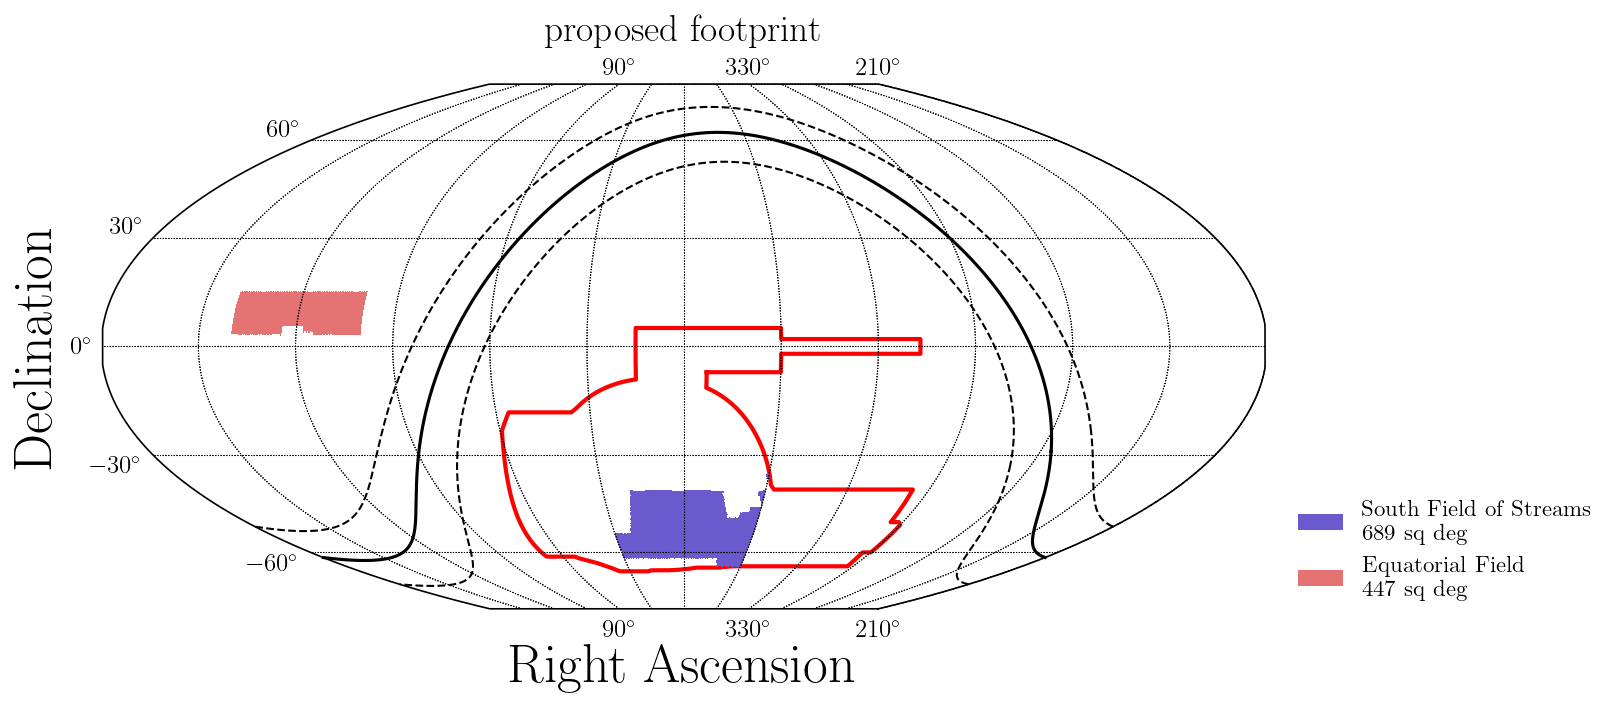

In [74]:
# --- Figure / projection ---
fig = plt.figure(1, figsize=(10, 5), dpi=150)
fig.clf()
ax = fig.add_subplot(111)
sp = skyproj.DESMcBrydeSkyproj(ax=ax, extent=[0, 360, -90, 90])



legend_handles = []

# --- Draw layers --- 
for label, cfg in new_footprints_dict.items(): 
    cmap = ListedColormap([cfg["color"]]) 

    sp.draw_hpxmap( cfg["map"], zoom=False, cmap=cmap, alpha=cfg['alpha'], zorder=cfg['zorder']) 
    legend_handles.append( mpatches.Patch( facecolor=cfg["color"], alpha=cfg['alpha'], label=label, ) ) 
    
# --- Legend --- 
sp.ax.legend( handles=legend_handles, loc=(1.02, 0), edgecolor="None", fontsize=11) 
plt.title("proposed footprint", y=1.06,)

sp.draw_milky_way(zorder=9)
sp.draw_des(zorder=9)


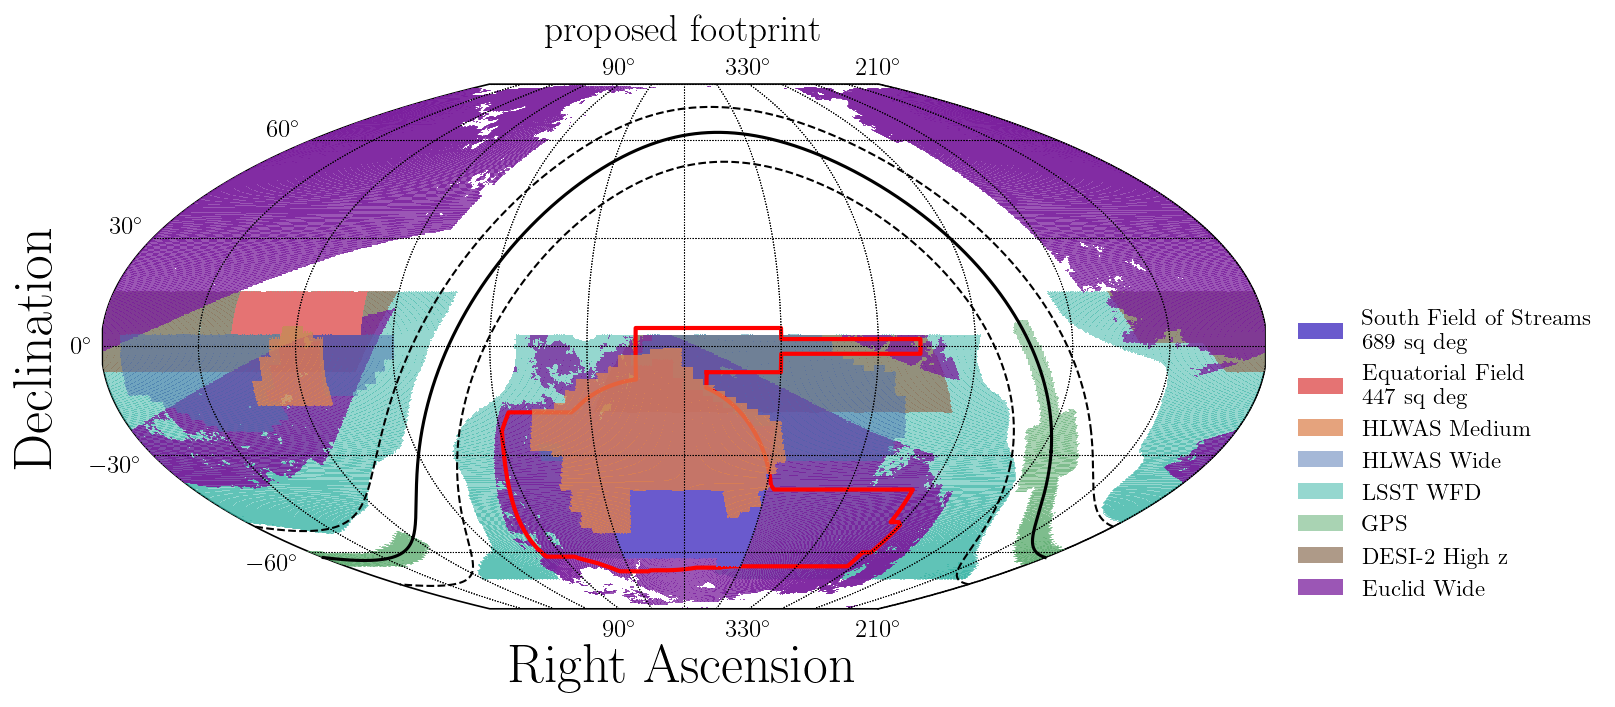

In [75]:

# --- Figure / projection ---
fig = plt.figure(1, figsize=(10, 5), dpi=150)
fig.clf()
ax = fig.add_subplot(111)
sp = skyproj.DESMcBrydeSkyproj(ax=ax, extent=[0, 360, -90, 90])



legend_handles = []

# --- Draw layers --- 
for label, cfg in footprints_dict.items(): 
    cmap = ListedColormap([cfg["color"]]) 

    sp.draw_hpxmap( cfg["map"], zoom=False, cmap=cmap, alpha=cfg['alpha'], zorder=cfg['zorder']) 
    legend_handles.append( mpatches.Patch( facecolor=cfg["color"], alpha=cfg['alpha'], label=label, ) ) 
    
# --- Legend --- 
sp.ax.legend( handles=legend_handles, loc=(1.02, 0), edgecolor="None", fontsize=11) 
plt.title("proposed footprint", y=1.06,)

sp.draw_milky_way(zorder=9)
sp.draw_des(zorder=9)





# 4 Check if you fav coords are in the footprint

In [10]:
def coords_in_footprint(hp_map, ra, dec):
    """
    check: return True where `hp_map` == 1.0 at given RA/Dec.

    - `ra` and `dec` must be provided separately (scalars or 1-D arrays).

    Returns a single bool for scalar inputs or a numpy boolean array for
    vector inputs.
    """
    arr = np.asarray(hp_map)
    nside = hp.npix2nside(arr.size)

    ra_vals = np.asarray(ra)
    dec_vals = np.asarray(dec)

    scalar = False
    if ra_vals.shape == () and dec_vals.shape == ():
        ra_vals = np.atleast_1d(ra_vals)
        dec_vals = np.atleast_1d(dec_vals)
        scalar = True

    # normalize RA
    ra_vals = ra_vals % 360.0

    pix = hp.ang2pix(nside, ra_vals, dec_vals, lonlat=True)
    vals = arr[pix]

    res = vals == 1.0
    return bool(res[0]) if scalar else res

ra = 30 
dec = -50
print("ra", ra, "dec", dec, coords_in_footprint(southern_field, ra=ra, dec=dec))
ra = 30 
dec = 50
print("ra", ra, "dec", dec, coords_in_footprint(southern_field, ra=ra, dec=dec))

ra 30 dec -50 True
ra 30 dec 50 False
